In [1]:
# Script to plot individual kinetics (and thermo)
# and compare across mechanisms

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.offsetbox
import rmgpy.chemkin
import matplotlib.lines as mlines

import os
import sys
import seaborn as sns
import matplotlib.colors as mcolors

sys.path.append(os.path.join(os.environ['DFT_DIR'], '..', 'database'))
import database_fun

%matplotlib inline

In [3]:
# load Aramco and RMG mechanisms

# Aramco
mech_1_inp = '/home/moon/autoscience/aramco/flux_diagram/chem_annotated.inp'
mech_1_dict = '/home/moon/autoscience/aramco/species_dictionary.txt'
mech_1_label = 'Aramco 3.0'
species_listA, reaction_listA = rmgpy.chemkin.load_chemkin_file(mech_1_inp, mech_1_dict)

# RMG-min-1
mech_2_inp = '/home/moon/autoscience/fuels/butane_20240126/chem_annotated.inp'
mech_2_dict = '/home/moon/autoscience/fuels/butane_20240126/species_dictionary.txt'
mech_2_label = 'RMG-min-1'
species_list1, reaction_list1 = rmgpy.chemkin.load_chemkin_file(mech_2_inp, mech_2_dict)

# RMG-min-2
mech_3_inp = '/home/moon/autoscience/fuels/butane_20240501/chem_annotated.inp'
mech_3_dict = '/home/moon/autoscience/fuels/butane_20240501/species_dictionary.txt'
mech_3_label = 'RMG-min-7'
species_list7, reaction_list7 = rmgpy.chemkin.load_chemkin_file(mech_3_inp, mech_3_dict)

In [4]:
def get_reaction_indices(reaction_list, ref_rxn):
    reaction_indices = []
    for i in range(len(reaction_list)):
        if reaction_list[i].is_isomorphic(ref_rxn):
            reaction_indices.append(i)
    return reaction_indices

In [5]:
def reactions_in_same_direction(reactionA, reactionB):
    reactantsA = [x.smiles for x in reactionA.reactants]
    reactantsB = [x.smiles for x in reactionB.reactants]
        
    return reactantsA[0] in reactantsB

In [6]:
# Define reactions that were calculated. Each row of ten represents one round of mechanism improvement
plot_list = [
    288, 4724, 5046, 4778, 4736, 4729, 4728, 50, 4752, 5047,
    4779, 286, 246, 5596, 808, 915, 4732, 518, 4737, 5446,
    324, 4738, 7841, 804, 809, 4721, 245, 945, 213, 289,
    422, 805, 4796, 1077, 1111, 1706, 4917, 417, 319, # species 21 here
    313, 278, 314, 52, 5056, 405, 5102, 521, 404, 410,
    4733, 296, 321, 301, 280, 253, 459, 1736, 1778, 299
]

In [7]:
# make reaction images for y axis labels
img_files = []
for rxn_idx in plot_list:
    rxn_file = f'r{rxn_idx:06}.png'
    r = database_fun.index2reaction(rxn_idx)
    r.draw(rxn_file)
    img_files.append(rxn_file)

In [8]:
def plot_kinetics(rxn_tuples, labels=None, title=''):
    """Function for plotting reaction kinetics
    """

    plt.figure(figsize=(5, 3.5))
    plt.xlabel('1000K / T', fontsize=12)
    plt.ylabel('log($k$)', fontsize=12)
#     linestyles = ['solid', 'dashed', 'dashdot']  # extra linestyles changed manually if lines overlap too much
    linestyles = ['solid', 'dotted', (0, (5, 10))]
    linestyles = ['solid', 'solid', 'solid']
#     linestyles = ['solid', 'dotted', 'solid']
    
    start_color = (1.0, 0.8, 0.0)  # RMG-min-1 color
    end_color = mcolors.hex2color(mcolors.CSS4_COLORS['forestgreen'])  # RMG-min-7 color
    aramco_color = (0.18627451, 0.48823529, 0.94117647)
    colors = sns.blend_palette([start_color, end_color], n_colors=7, as_cmap=False, input='rgb')
    colors[1] = end_color
    colors[2] = aramco_color
    
    T = np.linspace(300, 3000, 1001)
    for f, rxn_tuple in enumerate(rxn_tuples):
        k = np.ones(len(T))
        if rxn_tuple:
            for i in range(0, len(T)):
                k[i] = np.sum([rxn.get_rate_coefficient(T[i], 1013250) for rxn in rxn_tuple])
                
            plt.plot(1000.0 / T, np.log10(k), linestyle=linestyles[f], color=colors[f], zorder=10)
        else:  # no kinetics
            pass
#             plt.plot(1000.0 / T, np.log10(k), linestyle=linestyles[f], color=colors[f])

    if labels:
        plt.legend(labels, loc='lower left', fontsize=9)

    ax = plt.gca()
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    plt.show()


def plot_thermos(thermos, labels=None):
    # function for plotting thermodynamics: H, S, Cp
    if type(thermos) != list:
        thermos = [thermos]
    if labels is None:
        labels = ['' for t in thermos]
        
    start_color = (1.0, 0.8, 0.0)
    end_color = mcolors.hex2color(mcolors.CSS4_COLORS['forestgreen'])
    aramco_color = (0.18627451, 0.48823529, 0.94117647)
    colors = sns.blend_palette([start_color, end_color], n_colors=7, as_cmap=False, input='rgb')
    colors[1] = end_color
    colors[2] = aramco_color
        
    fig, ax = plt.subplots(1, 3)
    fig.set_size_inches(12, 3)
    fig.tight_layout()
    ax[0].set_xlabel('Temperature (K)')
    ax[0].set_ylabel('H (kJ / mol)')
    ax[0].set_title('Enthalpy vs. Temperature')
    ax[1].set_xlabel('Temperature (K)')
    ax[1].set_ylabel('S (kJ / mol K)')
    ax[1].set_title('Entropy vs. Temperature')
    ax[2].set_xlabel('Temperature (K)')
    ax[2].set_ylabel('Cp (kJ / mol K)')
    ax[2].set_title('Heat Capacity vs. Temperature')
    T = np.linspace(300, 3000, 1001)
    for m, thermo in enumerate(thermos):
        H = np.zeros(len(T))
        S = np.zeros(len(T))
        Cp = np.zeros(len(T))
        for i in range(0, len(T)):
            H[i] = thermo.get_enthalpy(T[i]) / 1000.0
            S[i] = thermo.get_entropy(T[i]) / 1000.0
            Cp[i] = thermo.get_heat_capacity(T[i]) / 1000.0
        ax[0].plot(T, H, color=colors[m])
        ax[1].plot(T, S, color=colors[m])
        ax[2].plot(T, Cp, color=colors[m])
    ax[0].legend(labels)
    ax[1].legend(labels)
    ax[2].legend(labels)
    
    ax[0].spines['right'].set_visible(False)
    ax[0].spines['top'].set_visible(False)
    ax[1].spines['right'].set_visible(False)
    ax[1].spines['top'].set_visible(False)
    ax[2].spines['right'].set_visible(False)
    ax[2].spines['top'].set_visible(False)
    
    plt.subplots_adjust(wspace=0.25)
    plt.show()

In [9]:
def print_smiles(reaction):
    smiles_str = ''
    for r in reaction.reactants:
        smiles_str += r.smiles + ' + '
    smiles_str = smiles_str[:-3]
    
    smiles_str += ' = '
    
    for p in reaction.products:
        smiles_str += p.smiles + ' + '
    smiles_str = smiles_str[:-3]
    return smiles_str

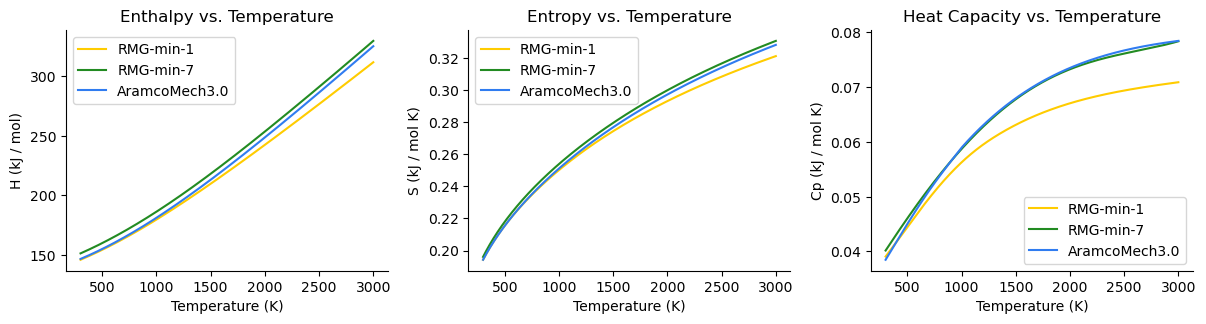

In [10]:
# plot the thermo for species 21, the one species that was calculated
ref_sp = database_fun.index2species(21)
display(ref_sp)
for i in range(len(species_list1)):
    if species_list1[i].is_isomorphic(ref_sp):
        sp21_1 = species_list1[i]
        
for i in range(len(species_list7)):
    if species_list7[i].is_isomorphic(ref_sp):
        sp21_7 = species_list7[i]
        
for i in range(len(species_listA)):
    if species_listA[i].is_isomorphic(ref_sp):
        sp21_A = species_listA[i]

my_labels = ['RMG-min-1', 'RMG-min-7', 'AramcoMech3.0']
plot_thermos([sp21_1, sp21_7, sp21_A], labels=my_labels)

1 288


CCCC + [OH] = O + [CH2]CCC


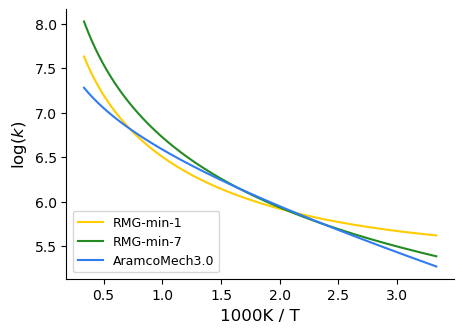

2 4724


OO + C[CH]CC = CCCC + [O]O
Reversing Aramco


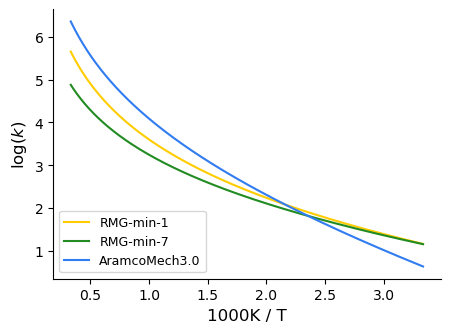

3 5046


COO + C[CH]CC = CCCC + CO[O]
Reversing Aramco


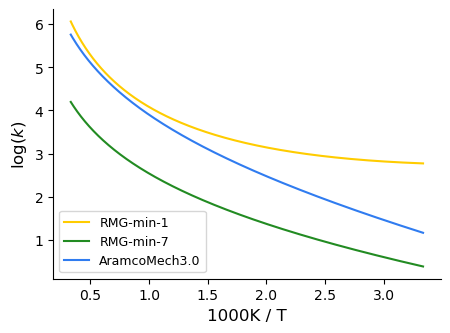

4 4778


C[CH]CC + CCCCOO = CCCC + CCCCO[O]
Reversing Aramco


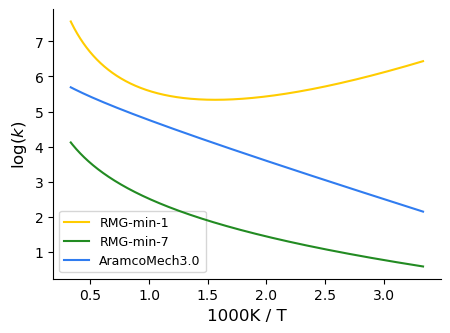

5 4736


OO + [CH2]CCC = CCCC + [O]O
Reversing Aramco


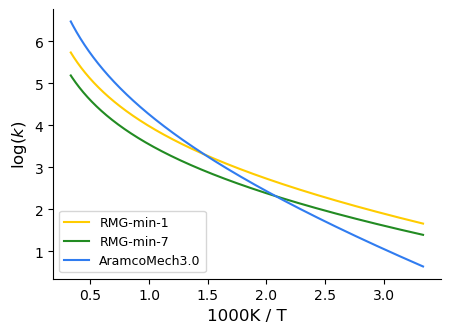

In [12]:
# Plot the specified kinetics from the plot_list
for m, db_index in enumerate(plot_list[0:5]):  # doing 5 at a time for easier display
    
    if m >= 30:  # Parameter 30 is species 21, so this accounts for the missing index in the list of kinetics
        print(m + 2, db_index)
    else:
        print(m + 1, db_index)
    
    ref_rxn = database_fun.index2reaction(db_index)  # This is the reference for the direction
    my_kinetics = []
    my_labels = ['RMG-min-1', 'RMG-min-7', 'AramcoMech3.0']
    display(ref_rxn)  # draw the reaction
    
    # Find all of the kinetics in RMG-min-1
    matches1 = get_reaction_indices(reaction_list1, ref_rxn)
    if matches1:
        rxn1_kinetics = []
        for m in range(len(matches1)):
            # check for reverse
            if not reactions_in_same_direction(reaction_list1[matches1[m]], ref_rxn):
                print('Reversing RMG-min-1', db_index)
                rxn1_kinetics.append(reaction_list1[matches1[m]].generate_reverse_rate_coefficient())
            else:
                rxn1_kinetics.append(reaction_list1[matches1[m]])
        my_kinetics.append(rxn1_kinetics)
    else:
        my_kinetics.append(None)
    if len(matches1) > 1:
        print('multiple kinetics for ', db_index)
        
    
    # Find all of the kinetics in RMG-min-7
    matches7 = get_reaction_indices(reaction_list7, ref_rxn)
    if matches7:
        rxn7_kinetics = []
        for m in range(len(matches7)):
            # check for reverse
            if not reactions_in_same_direction(reaction_list7[matches7[m]], ref_rxn):
                print('Reversing RMG-min-7', db_index)
                rxn7_kinetics.append(reaction_list7[matches7[m]].generate_reverse_rate_coefficient())
            else:
                rxn7_kinetics.append(reaction_list7[matches7[m]])
        my_kinetics.append(rxn7_kinetics)
    else:
        my_kinetics.append(None)


    print(print_smiles(ref_rxn))
    
    matchesA = get_reaction_indices(reaction_listA, ref_rxn)
    if matchesA:
        if len(matchesA) > 1:
            print('Aramco has duplicates!')
            raise ValueError
        
        # check for reverse
        if not reactions_in_same_direction(reaction_listA[matchesA[0]], reaction_list7[matches7[0]]):
            print('Reversing Aramco')
            my_kinetics.append([reaction_listA[matchesA[0]].generate_reverse_rate_coefficient()])
        else:
            my_kinetics.append([reaction_listA[matchesA[0]]])
    else:
        my_kinetics.append(None)
        

    
    if not my_kinetics[0]:  # no Aramco, so trim the labels accordingly
        my_labels = my_labels[1:]
    
    plot_kinetics(my_kinetics, my_labels, title=f'Reaction {db_index}')

